In [1]:
import pandas as pd

from hiveengine.api import Api 
from pycoingecko import CoinGeckoAPI

import datetime
import time
import calendar
import mplfinance as mpf
import matplotlib.pyplot as plt


In [2]:
api = Api() 
cg = CoinGeckoAPI()

In [3]:
hive_price_14=cg.get_coin_market_chart_by_id('hive','usd', days=14)

In [4]:
def convert_to_date_timestamp(d):
    d_new = datetime.datetime.fromtimestamp(d/1000)
    d_new = d_new.date()
    return int(time.mktime(d_new.timetuple()))

In [5]:
#group by date 

def convert_to_bar(coin_price):
    p_new = []
    p_collect =dict()
    for p in coin_price:
        p_new.append([convert_to_date_timestamp(p[0]),p[1]])
    #print(p_new)
    for p in p_new:
        if p[0] not in p_collect.keys():
            p_collect[p[0]] = [p[1]]
        else:
            p_collect[p[0]].append(p[1])

    #lowestPrice
    #highestPrice
    #openPrice
    #closePrice

    p_bar = {'timestamp': [], 'lowestPrice' : [] , 'highestPrice' : [], 'openPrice' : [] , 'closePrice' : []}

    for d in p_collect.keys():
        p=p_collect[d]

        p_bar['timestamp'].append(d)
        p_bar['lowestPrice'].append(min(p))
        p_bar['highestPrice'].append(max(p))
        p_bar['openPrice'].append(p[0])
        p_bar['closePrice'].append(p[-1])

    return p_bar

In [6]:
p_bar= convert_to_bar(hive_price_14['prices'])
dh = pd.DataFrame.from_dict(p_bar)
dh.head()

,timestamp,lowestPrice,highestPrice,openPrice,closePrice
0,1633017600,0.620219,0.635762,0.620219,0.622275
1,1633104000,0.622056,0.649519,0.625241,0.648223
2,1633190400,0.645695,0.720774,0.647453,0.675738
3,1633276800,0.669623,0.729600,0.686003,0.685869
4,1633363200,0.664826,0.700324,0.675497,0.673827


In [7]:
# mplfinance format

def reformat_to_bar(df):
    df_plot = dict()
    df_plot['Date'] = [datetime.datetime.fromtimestamp(t) for t in df['timestamp'] ]
    df_plot['Low'] = df['lowestPrice']
    df_plot['High'] = df['highestPrice']
    df_plot['Close'] = df['closePrice']
    df_plot['Open'] = df['openPrice']
    df_plot = pd.DataFrame(df_plot)
    df_plot.set_index('Date',inplace=True)
    return df_plot
    

In [8]:
token = 'LEO' # insert your fav token here
url4 = "https://accounts.hive-engine.com/marketHistory?symbol=" + token
df = pd.read_json(url4)
df['timestamp'] = [ int(time.mktime(datetime.datetime.strptime(str(s), "%Y-%m-%d %H:%M:%S").timetuple())) for s in df['timestamp']]

n_bar = {'timestamp': [], 'lowestPrice' : [] , 'highestPrice' : [], 'openPrice' : [] , 'closePrice' : []}
h_bar = {'timestamp': [], 'lowestPrice' : [] , 'highestPrice' : [], 'openPrice' : [] , 'closePrice' : []}
f_bar = {'timestamp': [], 'lowestPrice' : [] , 'highestPrice' : [], 'openPrice' : [] , 'closePrice' : []}


if len(dh) <= len(df):
    for t in dh.timestamp:
        if t in list(df.timestamp):
            n_bar['timestamp'].append(t)
            n_bar['lowestPrice'].append(float(dh[dh.timestamp==t]['lowestPrice'])*float(df[df.timestamp==t]['lowestPrice']))
            n_bar['highestPrice'].append(float(dh[dh.timestamp==t]['highestPrice'])*float(df[df.timestamp==t]['highestPrice']))
            n_bar['openPrice'].append(float(dh[dh.timestamp==t]['openPrice'])*float(df[df.timestamp==t]['openPrice']))
            n_bar['closePrice'].append(float(dh[dh.timestamp==t]['closePrice'])*float(df[df.timestamp==t]['closePrice']))

            
            h_bar['timestamp'].append(t)
            h_bar['lowestPrice'].append(float(dh[dh.timestamp==t]['lowestPrice']))
            h_bar['highestPrice'].append(float(dh[dh.timestamp==t]['highestPrice']))
            h_bar['openPrice'].append(float(dh[dh.timestamp==t]['openPrice']))
            h_bar['closePrice'].append(float(dh[dh.timestamp==t]['closePrice']))

            
            f_bar['timestamp'].append(t)
            f_bar['lowestPrice'].append(float(df[df.timestamp==t]['lowestPrice']))
            f_bar['highestPrice'].append(float(df[df.timestamp==t]['highestPrice']))
            f_bar['openPrice'].append(float(df[df.timestamp==t]['openPrice']))
            f_bar['closePrice'].append(float(df[df.timestamp==t]['closePrice']))
            
    

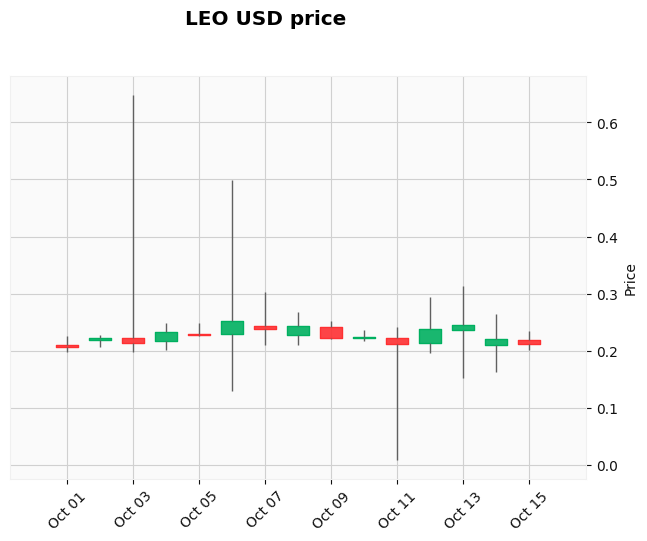

In [9]:
#token price versus dollar
n_bar_plot = reformat_to_bar(n_bar)
mpf.plot(n_bar_plot, type='candle', style='yahoo', title= f'{token} USD price')

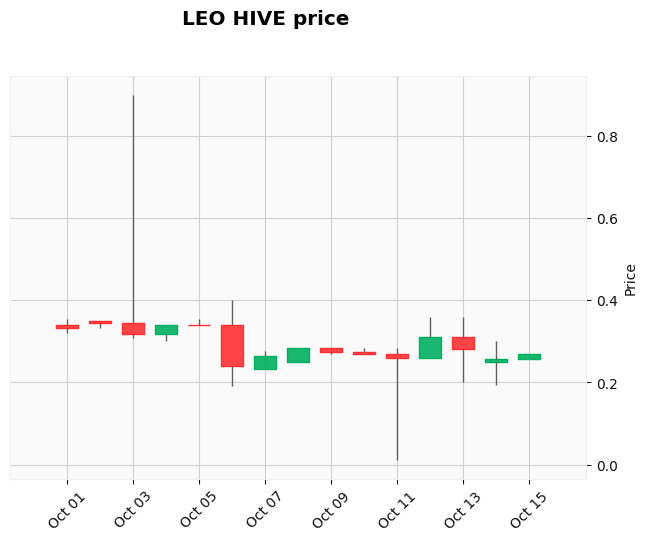

In [10]:
#token price versus hive
f_bar_plot = reformat_to_bar(f_bar)
mpf.plot(f_bar_plot, type='candle', style='yahoo' , title= f'{token} HIVE price')

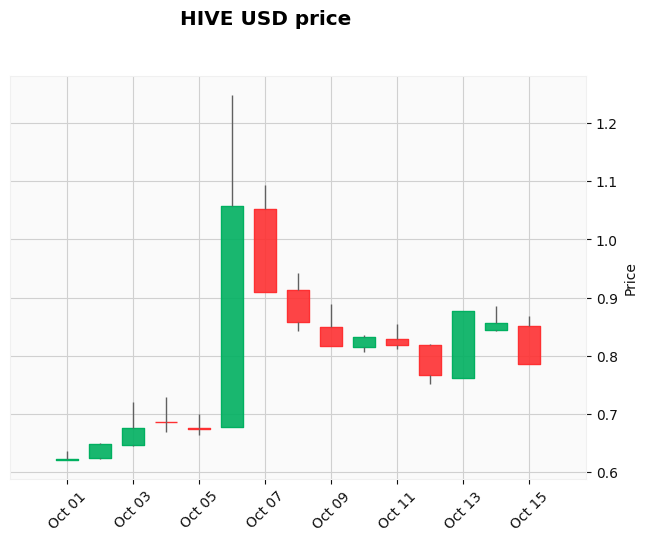

In [11]:
hive_bar_plot = reformat_to_bar(h_bar)
#hive_price
mpf.plot(hive_bar_plot, type='candle', style='yahoo', title='HIVE USD price')

Text(0.5, 1.0, 'Close/Open daily gain with respect to USD')

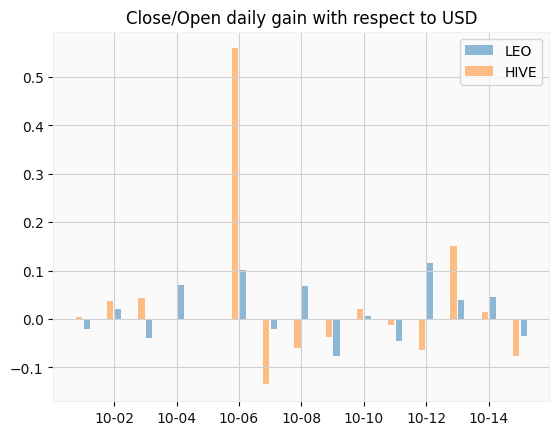

In [12]:
import matplotlib.dates as mdates

fig , ax = plt.subplots()

ax.bar(pd.to_datetime(f_bar_plot.index + datetime.timedelta(hours=3), unit='d') , n_bar_plot['Close']/n_bar_plot['Open']-1, width=0.2,alpha=0.5, label = token )
ax.bar(pd.to_datetime(hive_bar_plot.index - + datetime.timedelta(hours=3), unit='d'), hive_bar_plot['Close']/hive_bar_plot['Open']-1, width=0.2,alpha=0.5, label = 'HIVE')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_xticks(pd.to_datetime(f_bar_plot.index, unit='d')[1::2])

#ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis_date()
ax.legend(loc = 'upper right')
ax.set_title('Close/Open daily gain with respect to USD')
